In [15]:
import numpy as np
import math
from scipy.optimize import linear_sum_assignment

def generate_synthetic_scenario(n_frames=100, noise_params=None):

    # Генерация Ground Truth траекторий и зашумленных детекций.
    if noise_params is None:
        # Параметры шума измерений (Матрица R в концепции фильтра Калмана)
        noise_params = {'sigma_pos': 0.15, 'sigma_yaw': 0.05, 'sigma_dim': 0.1}
    
    gt_data = []
    detections = []
    
    for t in range(n_frames):
        frame_gt = []
        frame_dets = []
        time = t * 0.1  
        
        # Синусоидальное движение (проверка устойчивости к изменению ускорения)
        x0, y0 = 1.5 * time, 5 + 2.0 * np.sin(0.5 * time)
        yaw0 = np.arctan2(2.0 * 0.5 * np.cos(0.5 * time), 1.5) 
        w0, h0 = 2.0 + 0.2 * np.sin(time), 4.0 # Динамическое изменение размеров
        frame_gt.append({'id': 0, 'box': np.array([x0, y0, 0, yaw0, w0, h0])})
        
        # Круговое движение (проверка оценки угловой скорости)
        radius, omega = 8.0, 0.2
        x1, y1 = 10 + radius * np.cos(omega * time), 10 + radius * np.sin(omega * time)
        yaw1 = omega * time + np.pi/2
        w1, h1 = 3.0, 1.5 + 0.5 * np.cos(time)
        frame_gt.append({'id': 1, 'box': np.array([x1, y1, 0, yaw1, w1, h1])})
        
        # Линейное движение
        x2, y2 = -5 + 1.0 * time, -5 + 1.0 * time
        frame_gt.append({'id': 2, 'box': np.array([x2, y2, 0, np.pi/4, 2.0, 2.0])})
        
        # Формирование детекций с наложением гауссовского шума
        for obj in frame_gt:
            det_box = obj['box'].copy()
            det_box[0:3] += np.random.normal(0, noise_params['sigma_pos'], 3)
            det_box[3] += np.random.normal(0, noise_params['sigma_yaw'])
            det_box[4:6] += np.random.normal(0, noise_params['sigma_dim'], 2)
            frame_dets.append(det_box)
        
        np.random.shuffle(frame_dets) 
        gt_data.append(frame_gt)
        detections.append(frame_dets)
        
    return gt_data, detections

In [16]:
def evaluate_tracking_performance(gt_data, tracker_history, dist_threshold=2.0):
    
    # MAE (Mean Absolute Error) и Matching Accuracy
    total_gt_objects = 0
    total_matches = 0
    position_errors = []
    
    for t in range(len(gt_data)):
        gts = gt_data[t] 
        trks = tracker_history[t] 
        total_gt_objects += len(gts)
        
        if not gts or not trks: continue
            
        # Построение матрицы расстояний 
        cost_matrix = np.zeros((len(gts), len(trks)))
        for i, gt in enumerate(gts):
            for j, trk in enumerate(trks):
                dist = np.linalg.norm(gt['box'][0:2] - trk['box'][0:2])
                cost_matrix[i, j] = dist
                
        # Венгерский алгоритм для корректного подсчета метрик
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        
        for r, c in zip(row_ind, col_ind):
            dist = cost_matrix[r, c]
            if dist < dist_threshold:
                total_matches += 1
                position_errors.append(dist)
                
    mae = np.mean(position_errors) if position_errors else 0.0
    accuracy = total_matches / total_gt_objects if total_gt_objects > 0 else 0.0
    
    return {'MAE_Pos': mae, 'Matching_Accuracy': accuracy}

# Тестовая проверка 
gt_test, det_test = generate_synthetic_scenario(n_frames=5)
print(f"Sample detection (6D): {det_test[0][0]}")

Sample detection (6D): [ 1.76379828e+01  1.00687023e+01 -1.53718835e-02  1.58508333e+00
  3.05024883e+00  2.03938088e+00]


In [17]:
def calculate_box_iou(box1, box2):
    
    # Расчет IoU для прямоугольников (AABB) в плоскости BEV
    cx1, cy1, w1, h1 = box1[0], box1[1], box1[4], box1[5]
    cx2, cy2, w2, h2 = box2[0], box2[1], box2[4], box2[5]
    
    x1_min, y1_min, x1_max, y1_max = cx1-w1/2, cy1-h1/2, cx1+w1/2, cy1+h1/2
    x2_min, y2_min, x2_max, y2_max = cx2-w2/2, cy2-h2/2, cx2+w2/2, cy2+h2/2
    
    inter_xmin, inter_ymin = max(x1_min, x2_min), max(y1_min, y2_min)
    inter_xmax, inter_ymax = min(x1_max, x2_max), min(y1_max, y2_max)
    
    inter_area = max(0, inter_xmax - inter_xmin) * max(0, inter_ymax - inter_ymin)
    union_area = (w1 * h1) + (w2 * h2) - inter_area
    return inter_area / union_area if union_area > 0 else 0.0

class BoxKalmanFilter:

    # Реализация фильтра Калмана с 10-мерным вектором состояния
    # Включает: [x, y, z, vx, vy, vz, yaw, vyaw, w, h]
    def __init__(self, detection, track_id, Q_params=None, R_params=None):
        self.id = track_id
        # Параметризация шумов 
        self.Q_params = Q_params or {'pos': 0.1, 'vel': 1.0, 'yaw': 0.1, 'vyaw': 1.0, 'dim': 0.05}
        self.R_params = R_params or {'pos': 0.2, 'z': 0.5, 'yaw': 0.1, 'dim': 0.2}

        # Инициализация состояния x 
        self.x = np.zeros((10, 1))
        self.x[0], self.x[1], self.x[2], self.x[6], self.x[8], self.x[9] = \
            detection[0], detection[1], detection[2], detection[3], detection[4], detection[5]
        
        # Начальная ковариация P: высокая неопределенность для скоростей
        self.P = np.eye(10) * 10.0
        for i in [0, 1, 2, 6, 8, 9]: self.P[i, i] = 1.0
        
        self.time_since_update = 0
        self.hits = 1

    def predict(self, dt=1.0):
        # x = Fx, P = FPF' + Q (Модель постоянной скорости)
        F = np.eye(10)
        F[0, 3], F[1, 4], F[2, 5], F[6, 7] = dt, dt, dt, dt
        
        p = self.Q_params
        q_diag = [p['pos']*dt]*3 + [p['vel']*dt]*3 + [p['yaw']*dt, p['vyaw']*dt] + [p['dim']*dt]*2
        Q = np.diag(q_diag)
        
        self.x = F @ self.x
        self.P = F @ self.P @ F.T + Q
        self.time_since_update += 1

    def update(self, detection):
        # Шаг коррекции: обновление состояния по детекции 
        H = np.zeros((6, 10)) 
        H[0,0], H[1,1], H[2,2], H[3,6], H[4,8], H[5,9] = 1, 1, 1, 1, 1, 1
        
        p = self.R_params
        R = np.diag([p['pos'], p['pos'], p['z'], p['yaw'], p['dim'], p['dim']])
        
        z = detection.reshape(6, 1)
        y = z - H @ self.x # Инновация
        y[3] = (y[3] + np.pi) % (2 * np.pi) - np.pi # Нормализация yaw
        
        S = H @ self.P @ H.T + R
        K = self.P @ H.T @ np.linalg.inv(S) # Коэффициент Калмана
        self.x = self.x + K @ y
        
        # Ограничение максимальной скорости 
        max_velocity = 10.0 
        vx, vy, vz = self.x[3,0], self.x[4,0], self.x[5,0]
        v_norm = np.sqrt(vx**2 + vy**2 + vz**2)
        if v_norm > max_velocity:
            self.x[3:6, 0] *= (max_velocity / v_norm)
            
        self.x[6] = (self.x[6] + np.pi) % (2 * np.pi) - np.pi
        self.P = (np.eye(10) - K @ H) @ self.P
        self.time_since_update = 0
        self.hits += 1

class MultiObjectTracker:

    # Система управления треками AB3DMOT 
    # Управление жизненным циклом и венгерский алгоритм
    def __init__(self, max_age=5, match_threshold=0.9, min_hits=3, Q_params=None, R_params=None):
        self.tracks = []
        self.next_id = 0
        self.max_age = max_age           # Макс. пропуск кадров 
        self.match_threshold = match_threshold # Reject-association 
        self.min_hits = min_hits         # Подтверждение трека 
        self.Q_params = Q_params
        self.R_params = R_params

    def process_frame(self, detections, dt=1.0):
        for tr in self.tracks: tr.predict(dt)

        assigned_tracks, assigned_dets = set(), set()
        if self.tracks and detections:
            # Расчет матрицы стоимостей на основе 1 - IoU 
            C = np.zeros((len(self.tracks), len(detections)))
            for i, tr in enumerate(self.tracks):
                t_box = tr.x[[0,1,2,6,8,9], 0]
                for j, det in enumerate(detections):
                    C[i, j] = 1.0 - calculate_box_iou(t_box, det)
            
            row_ind, col_ind = linear_sum_assignment(C)
            for r, c in zip(row_ind, col_ind):
                if C[r, c] < self.match_threshold:
                    self.tracks[r].update(detections[c])
                    assigned_tracks.add(r); assigned_dets.add(c)
        
        # Инициализация новых треков для неассоциированных детекций
        for j, det in enumerate(detections):
            if j not in assigned_dets:
                self.tracks.append(BoxKalmanFilter(det, self.next_id, self.Q_params, self.R_params))
                self.next_id += 1

        # Удаление старых треков 
        self.tracks = [t for t in self.tracks if t.time_since_update < self.max_age]
        
    def get_confirmed_tracks(self):
        # Возвращает только подтвержденные объекты 
        return [{'id': tr.id, 'box': tr.x[[0,1,2,6,8,9], 0]} 
                for tr in self.tracks if tr.hits >= self.min_hits and tr.time_since_update <= 1]

In [18]:
def run_multi_target_simulation(n_frames=120):

    # Симуляция 5 объектов с пересекающимися траекториями
    gt_data, detections = [], []
    dt = 0.1
    for t in range(n_frames):
        frame_gt, frame_dets = [], []
        time = t * dt
        # Конфигурации движения: позиции, скорости и кривизна (lambda)
        configs = [
            {'id': 0, 'start': [0, 0], 'v': [2, 1], 'curve': lambda x: np.sin(x)},
            {'id': 1, 'start': [15, 0], 'v': [-1.5, 1.2], 'curve': lambda x: np.cos(x*0.5)*2},
            {'id': 2, 'start': [0, 15], 'v': [1.8, -1.2], 'curve': lambda x: 0},
            {'id': 3, 'start': [20, 20], 'v': [-2, -2], 'curve': lambda x: np.sin(x*0.3)*4},
            {'id': 4, 'start': [5, 20], 'v': [0.5, -2.5], 'curve': lambda x: np.cos(x)*3}
        ]
        for cfg in configs:
            x, y = cfg['start'][0] + cfg['v'][0]*time, cfg['start'][1] + cfg['v'][1]*time + cfg['curve'](time)
            w, h = 2.0 + 0.3*np.sin(time), 4.0 + 0.2*np.cos(time)
            box = np.array([x, y, 0, np.arctan2(cfg['v'][1], cfg['v'][0]), w, h])
            frame_gt.append({'id': cfg['id'], 'box': box})
            frame_dets.append(box + np.random.normal(0, 0.1, 6))
            
        np.random.shuffle(frame_dets)
        gt_data.append(frame_gt); detections.append(frame_dets)
    return gt_data, detections

# Трекинг
gt_multi, det_multi = run_multi_target_simulation()
tracker = MultiObjectTracker(max_age=10, match_threshold=0.8, min_hits=3)
tracking_results = []

for dets in det_multi:
    tracker.process_frame(dets, dt=0.1)
    tracking_results.append(tracker.get_confirmed_tracks())

# Количественная оценка 
metrics = evaluate_tracking_performance(gt_multi, tracking_results)
print(f"Tracking Metrics: {metrics}")

Tracking Metrics: {'MAE_Pos': 0.10088921673339817, 'Matching_Accuracy': 0.9833333333333333}


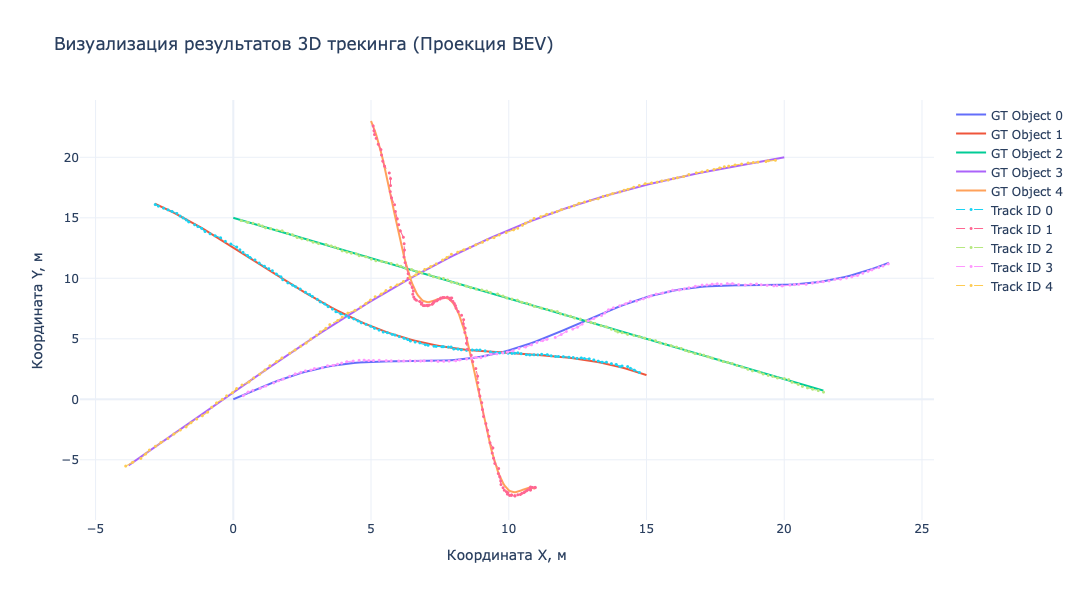

In [14]:
import plotly.graph_objects as go

def visualize_tracking_results(gt_data, results):

    # Визуализация истинных (GT) и восстановленных трекером траекторий
    fig = go.Figure()
    
    # Отрисовка Ground Truth 
    for i in range(5):
        pts = [frame[i]['box'] for frame in gt_data]
        fig.add_trace(go.Scatter(
            x=[p[0] for p in pts], 
            y=[p[1] for p in pts], 
            name=f'GT Object {i}', 
            line=dict(width=2)
        ))

    # Отрисовка траекторий, сформированных трекером 
    track_history = {}
    for frame in results:
        for trk in frame:
            tid = trk['id']
            if tid not in track_history: 
                track_history[tid] = {'x': [], 'y': []}
            track_history[tid]['x'].append(trk['box'][0])
            track_history[tid]['y'].append(trk['box'][1])

    for tid, path in track_history.items():
        fig.add_trace(go.Scatter(
            x=path['x'], 
            y=path['y'], 
            name=f'Track ID {tid}', 
            mode='lines+markers', 
            line=dict(dash='dash', width=1), 
            marker=dict(size=3)
        ))

    fig.update_layout(
        title="Визуализация результатов 3D трекинга (Проекция BEV)", 
        xaxis_title="Координата X, м", 
        yaxis_title="Координата Y, м", 
        width=1000, 
        height=600,
        template="plotly_white"
    )
    fig.show()

visualize_tracking_results(gt_multi, tracking_results)